In [3]:
# Purpose: Calculate LST

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 9.7 MB/s  0:00:029.4 MB/s eta 0:00:01:01
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [rasterio]━━ 3/4 [rasterio]


In [14]:
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import geopandas as gpd




In [15]:
# open band 4 red
band4 = rasterio.open('landsat20180603/LC08_L1TP_195021_20180603_20200831_02_T1_B4.tif') #red

#number of raster rows
band4.height
#number of raster columns
band4.width
#plot band 
plt.show(band4)
#type of raster byte
band4.dtypes[0]
#raster sytem of reference
band4.crs
#raster transform parameters
band4.transform
#raster values as matrix array
band4.read(1)



array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(7931, 7841), dtype=uint16)

In [29]:
# Open band 5 near-infrared
band5 = rasterio.open("landsat20180603/LC08_L1TP_195021_20180603_20200831_02_T1_B5.tif") #nir

# Open band 3 green for MNDWI = modified normalized difference water index
band3 = rasterio.open("landsat20180603/LC08_L1TP_195021_20180603_20200831_02_T1_B3.tif") 
# Open band 6 middle-infrared for MNDWI = modified normalized difference water index
band6 = rasterio.open("landsat20180603/LC08_L1TP_195021_20180603_20200831_02_T1_B5.tif") 


Min: 0.0
Max: 35977.0
Mean: 16932.53463049358
Unique Values: [    0. 19650. 19651. ... 35846. 35948. 35977.]


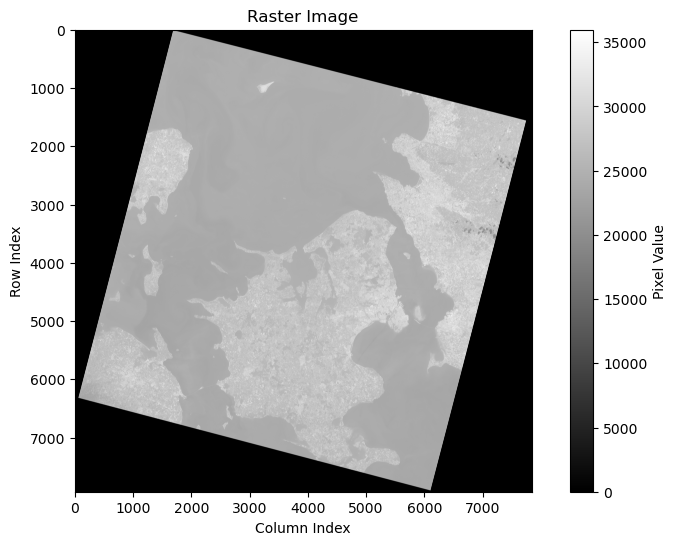

In [17]:
# Open band 10
band10 = rasterio.open('landsat20180603/LC08_L1TP_195021_20180603_20200831_02_T1_B10.tif') #red

# Debugging: Check NDVI values
print("Min:", np.min(band10.read(1).astype('float64')))
print("Max:", np.max(band10.read(1).astype('float64')))
print("Mean:", np.mean(band10.read(1).astype('float64')))
print("Unique Values:", np.unique(band10.read(1).astype('float64')))

# Plot the raster data
plt.figure(figsize=(10, 6))
plt.imshow(band10.read(1).astype('float64'), cmap='gray')  # Use 'gray' or 'viridis'
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

atmo_spec_rad Min: -0.18999999999999997
atmo_spec_rad Max: 11.833513400000001
atmo_spec_rad Mean: 5.468853073510954
atmo_spec_rad Unique Values: [-0.19       6.37703    6.3773642 ... 11.7897332 11.8238216 11.8335134]


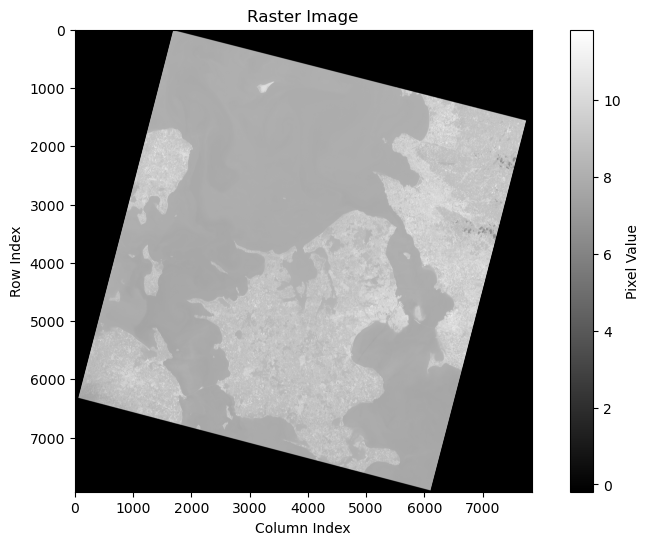

In [18]:
#F1.3.1 Atmosphere spectral radiance of band 10
#ML = band-specific multiplicative rescaling factor = RADIANCE_MULT_BAND_10 = 3.3420E-04
#Qcal = band 10
#AL = band-specific additive rescaling factor = RADIANCE_ADD_BAND_10 = 0.10000
# Convert DN to TOA reflectance
atmo_spec_rad_band10 = 0.0003342 * band10.read(1).astype('float64') + 0.10000-0.29

# Debugging: Check NDVI values
print("atmo_spec_rad Min:", np.min(atmo_spec_rad_band10))
print("atmo_spec_rad Max:", np.max(atmo_spec_rad_band10))
print("atmo_spec_rad Mean:", np.mean(atmo_spec_rad_band10))
print("atmo_spec_rad Unique Values:", np.unique(atmo_spec_rad_band10))

# Plot the raster data
plt.figure(figsize=(10, 6))
plt.imshow(atmo_spec_rad_band10, cmap='gray')  # Use 'gray' or 'viridis'
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

/var/folders/lv/q611jf7n7jqdmn102pr9m73w0000gp/T/ipykernel_13385/3249563911.py:4: RuntimeWarning: invalid value encountered in log
  brigthness_temp = (1321.0789/np.log((774.8853/atmo_spec_rad_band10)+1))-273.15


brigthness_temp Min: nan
brigthness_temp Max: nan
brigthness_temp Mean: nan
brigthness_temp Unique Values: [ 1.60491065  1.60788084  1.61382094 ... 41.56176781 41.62228377
         nan]


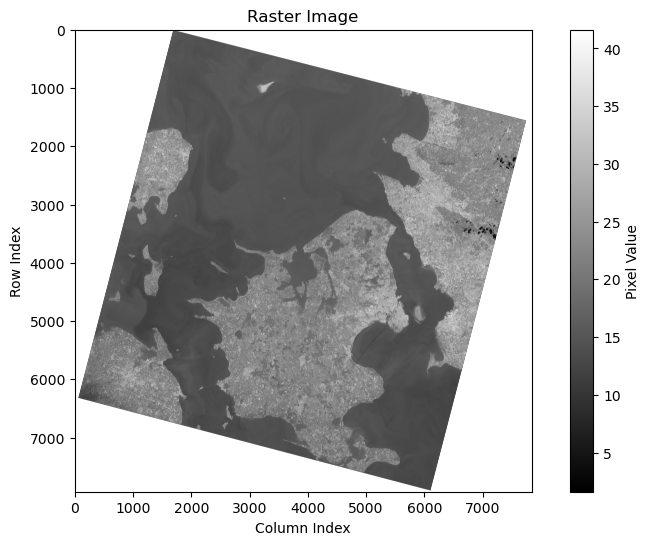

In [19]:
#F1.3 Brigtness temperature
# K1 = the first band-specific calibration constant = 774.89 = K1_CONSTANT_BAND_10 = 774.8853
# K2 = the second band-specific calibration constant = 1321.08 = K2_CONSTANT_BAND_10 = 1321.0789
brigthness_temp = (1321.0789/np.log((774.8853/atmo_spec_rad_band10)+1))-273.15
#brigthness_temp = 1321.0789/(np.log(774.8853/(atmo_spec_rad+1)))-273.15
# this is the standard method: Tb = K2 / np.log((K1 / L) + 1)

# Debugging: Check NDVI values
print("brigthness_temp Min:", np.min(brigthness_temp))
print("brigthness_temp Max:", np.max(brigthness_temp))
print("brigthness_temp Mean:", np.mean(brigthness_temp))
print("brigthness_temp Unique Values:", np.unique(brigthness_temp))

# Plot the raster data
plt.figure(figsize=(10, 6))
plt.imshow(brigthness_temp, cmap='gray')  # Use 'gray' or 'viridis'
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

/var/folders/lv/q611jf7n7jqdmn102pr9m73w0000gp/T/ipykernel_13385/863481518.py:10: RuntimeWarning: invalid value encountered in divide
  (nir - red) / (nir + red)


ndvi Min: -1.0
ndvi Max: 1.0
ndvi Mean: 0.09291638718826471
ndvi Unique Values: [-1.         -0.32866945 -0.30770512 ...  0.65101916  0.65193566
  1.        ]


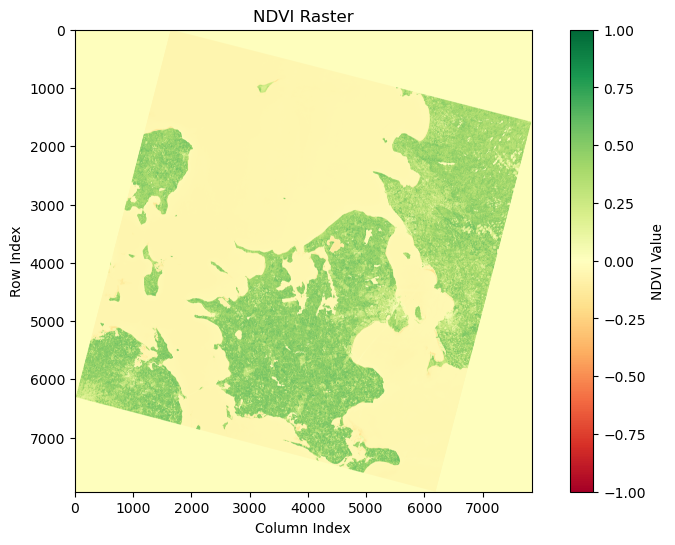

In [20]:
#F1.2.1.1 NDVI
#generate nir and red objects as arrays in float64 format
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')

# NDVI calculation, setting empty or no-data cells to 0
ndvi = np.where(
    (nir + red) == 0.,  # Avoid division by zero
    0, 
    (nir - red) / (nir + red)
)

# Debugging: Check NDVI values
print("ndvi Min:", np.min(ndvi))
print("ndvi Max:", np.max(ndvi))
print("ndvi Mean:", np.mean(ndvi))
print("ndvi Unique Values:", np.unique(ndvi))

# Display NDVI raster
fig = plt.figure(figsize=(10, 6))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)  # Use 'RdYlGn' for vegetation contrast
plt.colorbar(label="NDVI Value")
plt.title("NDVI Raster")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

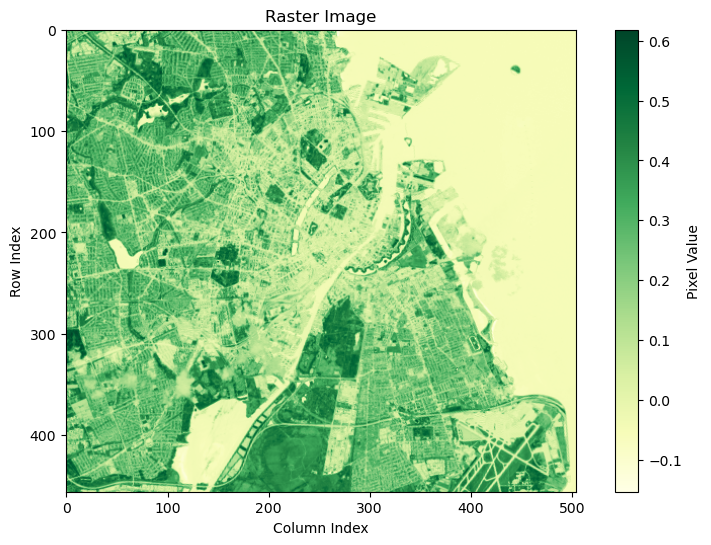

In [22]:
# NDVI AS A PARAMETER TO STORE
input_path = "landsat20180603/ndvi_draft.tif"
template_path = "landsat20180603/lst_case.tif"
output_path = "landsat20180603/ndvi_20180603.tif"

# update metadata 
with rasterio.open("landsat20180603/LC08_L1TP_195021_20180603_20200831_02_T1_B5.tif") as src:   # use the same file you used for `band4`
    data = src.read(1)
    meta = src.meta.copy()

meta.update({
    "dtype": "float32",
    "count": 1,
    "nodata": np.nan
})

with rasterio.open(input_path, "w", **meta) as dst:
    dst.write(ndvi.astype("float32"), 1)

# transform vegetation to raster template
with rasterio.open(input_path) as src, rasterio.open(template_path) as tpl:

    kwargs = tpl.meta.copy()
    kwargs.update({
        "count": src.count,
        "dtype": "float32",        # important for averaging
        "nodata": src.nodata
    })

    with rasterio.open(output_path, "w", **kwargs) as ndvi_ras:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(ndvi_ras, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=tpl.transform,
                dst_crs=tpl.crs,
                resampling=Resampling.average
            )

ndvi_ras = rasterio.open(output_path) 

# Plot vegetation transformed
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_ras.read(1).astype('float64'), cmap='YlGn')  
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

prop_of_veg Min: 0.0
prop_of_veg Max: 1.0
prop_of_veg Mean: 0.5464581935941324
prop_of_veg Unique Values: [0.         0.33566528 0.34614744 ... 0.82550958 0.82596783 1.        ]


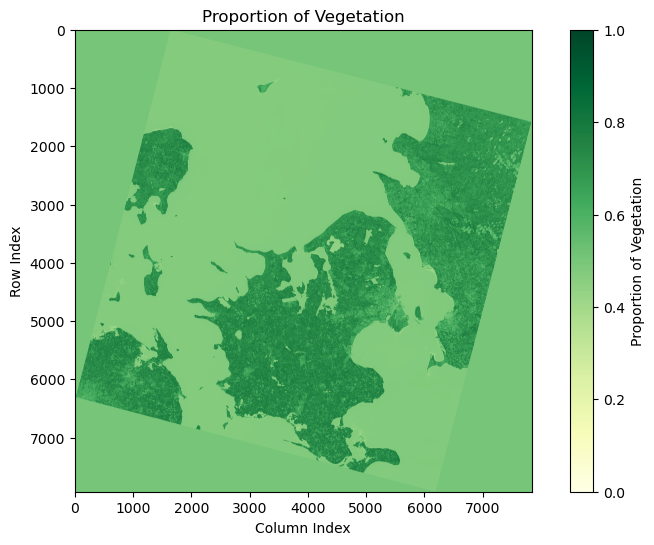

In [23]:
#F1.2.1 Proportion of vegetation 

prop_of_veg = (ndvi-np.min(ndvi))/(np.max(ndvi)-np.min(ndvi))

# Debugging: Check NDVI values
print("prop_of_veg Min:", np.min(prop_of_veg))
print("prop_of_veg Max:", np.max(prop_of_veg))
print("prop_of_veg Mean:", np.mean(prop_of_veg))
print("prop_of_veg Unique Values:", np.unique(prop_of_veg))

# Plot the raster
plt.figure(figsize=(10, 6))
plt.imshow(prop_of_veg, cmap='YlGn', vmin=np.min(prop_of_veg), vmax=np.max(prop_of_veg))  # 'YlGn' for vegetation
plt.colorbar(label="Proportion of Vegetation")
plt.title("Proportion of Vegetation")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()


emissivity Min: 0.986
emissivity Max: 0.99
emissivity Mean: 0.9881858327743763
emissivity Unique Values: [0.986      0.98734266 0.98738459 ... 0.98930204 0.98930387 0.99      ]


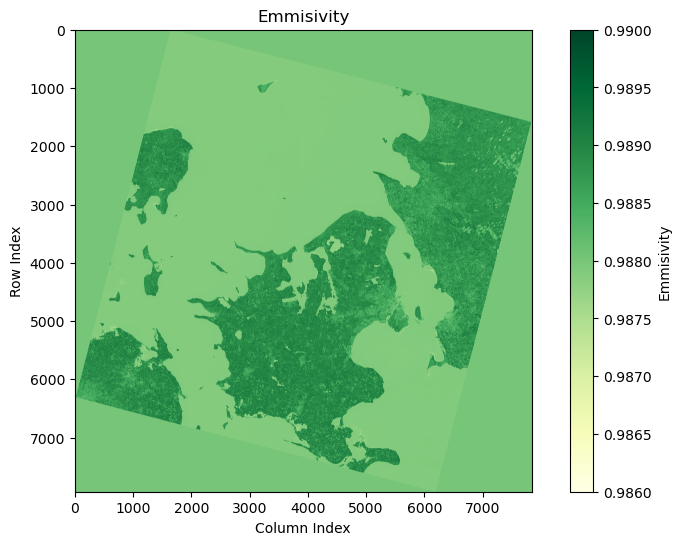

In [24]:
# F1.2 land surface emmisivity
emissivity=0.004*prop_of_veg+0.986

# Debugging: Check NDVI values
print("emissivity Min:", np.min(emissivity))
print("emissivity Max:", np.max(emissivity))
print("emissivity Mean:", np.mean(emissivity))
print("emissivity Unique Values:", np.unique(emissivity))

# Plot the raster
plt.figure(figsize=(10, 6))
plt.imshow(emissivity, cmap='YlGn', vmin=np.min(emissivity), vmax=np.max(emissivity))  # 'YlGn' for vegetation
plt.colorbar(label="Emmisivity")
plt.title("Emmisivity")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

lst Min: nan
lst Max: nan
lst Mean: nan
lst Unique Values: [ 1.60493402  1.60790429  1.61384458 ... 41.5774886  41.63807236
         nan]


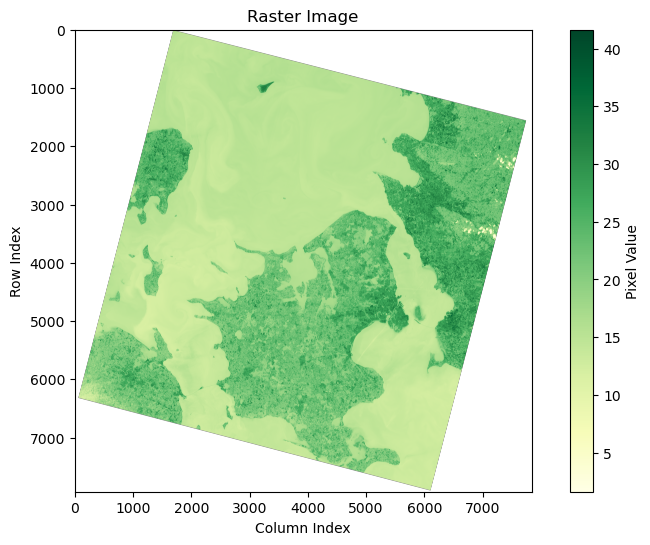

In [25]:
#F1.1 Constant P
#h=6.626*10^(-34)
#c=2.998*(10^8)
#bolz=1.38*10^(-23)
constant_p = 6.626e-34 * (2.998e8) / (1.38e-23) # in m·K
# Convert to µm·K (multiply by 10^6)
constant_p_micrometer = constant_p * 1e6

#F1 Land surface temperature
lst = brigthness_temp/(1+10.9*(brigthness_temp/constant_p_micrometer)*np.log(emissivity))
#lst = brigthness_temp/(1+10.9*(brigthness_temp/14388)*np.log(emissivity))

# Debugging: Check NDVI values
print("lst Min:", np.min(lst))
print("lst Max:", np.max(lst))
print("lst Mean:", np.mean(lst))
print("lst Unique Values:", np.unique(lst))

# Plot the raster data
plt.figure(figsize=(10, 6))
plt.imshow(lst, cmap='YlGn')  # Use 'gray' or 'viridis'
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

#Source: https://riski-saputra.medium.com/mapping-land-surface-temperature-lst-using-landsat-8-imagery-in-arcmap-99bd64f2c3fa

In [30]:
# CALCULATE MNDWI 

#generate nir and red objects as arrays in float64 format
green = band3.read(1).astype('float64') #green band
mir = band6.read(1).astype('float64') #middle infra-red band 

# MNDWI calculation, setting empty or no-data cells to 0
mndwi = np.where(
    (green - mir) == 0.,  # Avoid division by zero
    0, 
    (green - mir) / (green + mir)
)

# Debugging: Check NDVI values
print("mndwi Min:", np.min(mndwi))
print("mndwi Max:", np.max(mndwi))
print("mndwi Mean:", np.mean(mndwi))
print("mndwi Unique Values:", np.unique(mndwi))

/var/folders/lv/q611jf7n7jqdmn102pr9m73w0000gp/T/ipykernel_13385/1904818673.py:11: RuntimeWarning: invalid value encountered in divide
  (green - mir) / (green + mir)


mndwi Min: -1.0
mndwi Max: 1.0
mndwi Mean: -0.05549951599873251
mndwi Unique Values: [-1.         -0.65125858 -0.64654097 ...  0.37783901  0.4090945
  1.        ]


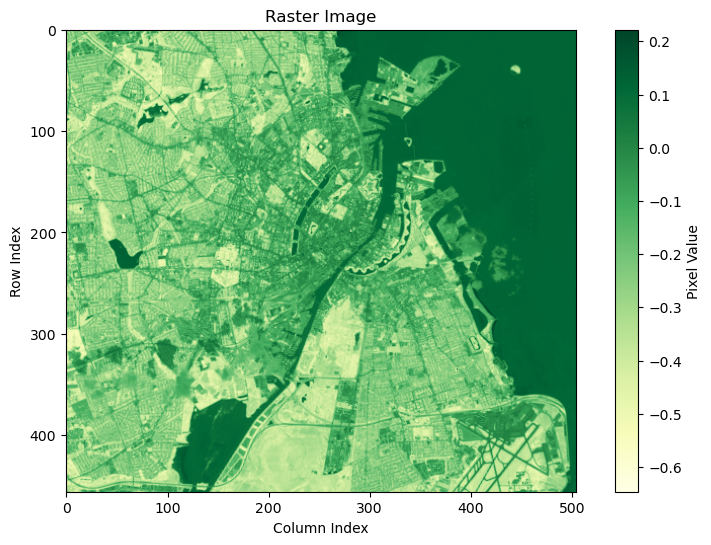

In [31]:
# MNDWI AS A PARAMETER TO STORE
input_path = "landsat20180603/mndwi_draft.tif"
template_path = "landsat20180603/lst_case.tif"
output_path = "landsat20180603/mndwi_20180603.tif"

# update metadata 
with rasterio.open("landsat20180603/LC08_L1TP_195021_20180603_20200831_02_T1_B3.tif") as src:   # use the same file you used for `band4`
    data = src.read(1)
    meta = src.meta.copy()

meta.update({
    "dtype": "float32",
    "count": 1,
    "nodata": np.nan
})

with rasterio.open(input_path, "w", **meta) as dst:
    dst.write(mndwi.astype("float32"), 1)

# transform vegetation to raster template
with rasterio.open(input_path) as src, rasterio.open(template_path) as tpl:

    kwargs = tpl.meta.copy()
    kwargs.update({
        "count": src.count,
        "dtype": "float32",        # important for averaging
        "nodata": src.nodata
    })

    with rasterio.open(output_path, "w", **kwargs) as mndwi_ras:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(mndwi_ras, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=tpl.transform,
                dst_crs=tpl.crs,
                resampling=Resampling.average
            )

mndwi_ras = rasterio.open(output_path) 

# Plot vegetation transformed
plt.figure(figsize=(10, 6))
plt.imshow(mndwi_ras.read(1).astype('float64'), cmap='YlGn')  
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

In [26]:
# Open original raster to get metadata
with rasterio.open(
    'landsat20180603/LC08_L1TP_195021_20180603_20200831_02_T1_B4.tif'
) as src:
    meta = src.meta.copy()

# Update metadata for your calculated array
meta.update({
    "dtype": lst.dtype,
    "count": 1
})

# Write new raster with same metadata
with rasterio.open("landsat20180603/lst_20180603_final.tif", "w", **meta) as dst:
    dst.write(lst, 1)


In [27]:
# Transfer raster to template raster 
input_path = "landsat20180603/lst_20180603_final.tif"
template_path = "landsat20180603/lst_case.tif"
output_path = "landsat20180603/lst_20180603_casedraft.tif"

with rasterio.open(input_path) as src_input, rasterio.open(template_path) as src_template:
    # Target CRS
    dst_crs = src_template.crs
    
    # Calculate transform, width, height for target CRS
    transform, width, height = calculate_default_transform(
        src_input.crs,
        dst_crs,
        src_input.width,
        src_input.height,
        *src_input.bounds
    )
    
    # Update metadata
    kwargs = src_input.meta.copy()
    kwargs.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })
    
    # Reproject and write new raster
    with rasterio.open(output_path, "w", **kwargs) as dst:
        for i in range(1, src_input.count + 1):
            reproject(
                source=rasterio.band(src_input, i),
                destination=rasterio.band(dst, i),
                src_transform=src_input.transform,
                src_crs=src_input.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear  
            )


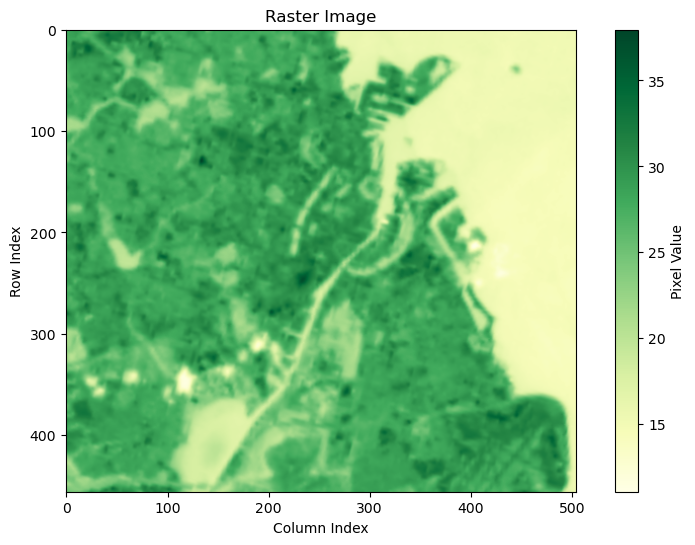

In [28]:
# Make extent match template raster
with rasterio.open("landsat20180603/lst_20180603_casedraft.tif") as src_lst, rasterio.open("landsat20180603/lst_case.tif") as src_mask:
    
    # Make sure CRS matches
    if src_lst.crs != src_mask.crs:
        raise ValueError("CRS mismatch!")

    # Get bounds of mask raster
    bounds2 = src_mask.bounds

    # Compute overlapping window on lst
    window = from_bounds(bounds2.left, bounds2.bottom, bounds2.right, bounds2.top, transform=src_lst.transform)

    # Read the window
    rast1_cropped = src_lst.read(1, window=window)

    # Update transform for the cropped array
    transform_cropped = src_lst.window_transform(window)

    # Update metadata
    meta = src_lst.meta.copy()
    meta.update({
        "height": rast1_cropped.shape[0],
        "width": rast1_cropped.shape[1],
        "transform": transform_cropped
    })

# Optionally write out
with rasterio.open("landsat20180603/lst_20180603_final.tif", "w", **meta) as dst:
    dst.write(rast1_cropped, 1)

dst = rasterio.open("landsat20180603/lst_20180603_final.tif")
    
# Plot the raster data
plt.figure(figsize=(10, 6))
plt.imshow(dst.read(1).astype('float64'), cmap='YlGn')  # Use 'gray' or 'viridis'
plt.colorbar(label="Pixel Value")
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

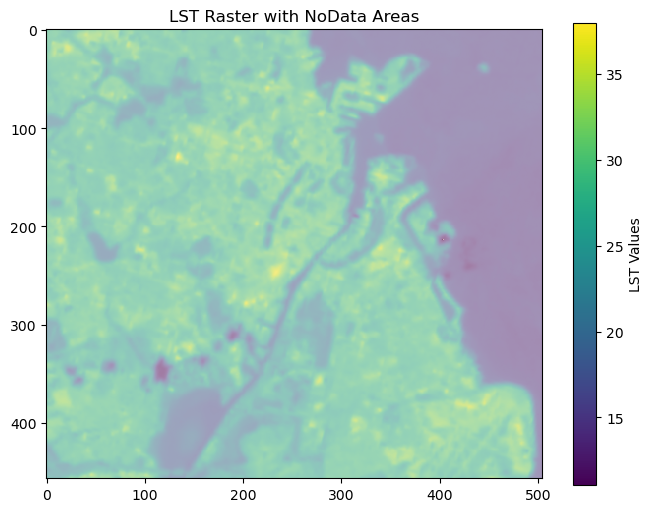

In [36]:
# SETUP - LST
lst = rasterio.open('landsat20180603/lst_20180603_final.tif').read(1).astype('float64') # Land surface temperature in study area Copenhagen

# Set NoData in LST
min_value = np.nanmin(lst)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst[lst == min_value] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask = np.isnan(lst)

# Plot raster and nodata areas
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(lst, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Overlay nodata areas
ax.imshow(nodata_mask, cmap="Reds", alpha=0.5)  # Red overlay for nodata areas
ax.set_title("LST Raster with NoData Areas")
plt.show()

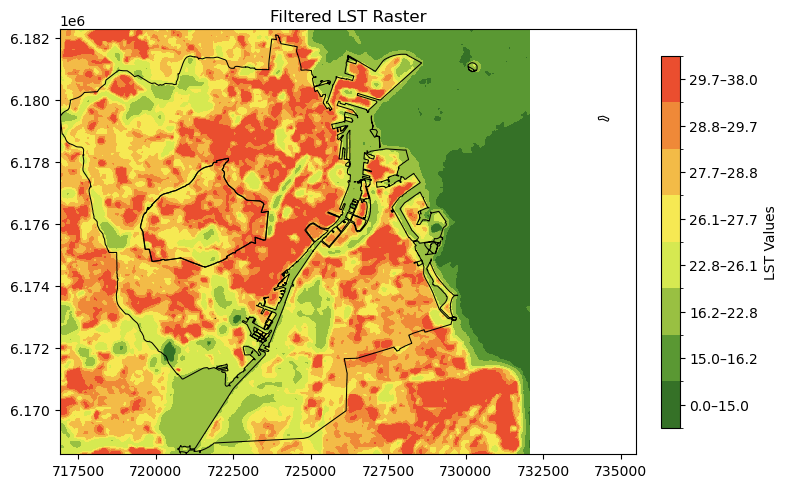

In [55]:
# LST FOR VISUALISATION
studyarea = gpd.read_file('analysis_input_data/case_study.gpkg') 

# Set NoData in LST
min_value = np.nanmin(lst)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst[lst == min_value] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask = np.isnan(lst)

# Define class edges and colors
lst_new_colorbins_lst = [0, 15.0, 16.2, 22.8, 26.1, 27.7, 28.8, 29.7, 38.0]
lst_new_colors_lst = ["#357127", "#5A9833", "#99C042", "#D6E951", "#F6E953", "#F3BB47", "#EF8938", "#EA4E2F"]
#lst_new_classes_lst = np.digitize(lst, lst_new_colorbins_lst, right=False) - 1
#lst_new_classes_lst[np.isnan(lst)] = -1  # mark NoData as -1
# Create colormap
lst_new_cmap_lst = ListedColormap(lst_new_colors_lst)
norm_lst = BoundaryNorm(lst_new_colorbins_lst, lst_new_cmap_lst.N)

# Assume you have a raster with transform
from rasterio.plot import plotting_extent

# Suppose lst comes from a raster file
with rasterio.open("landsat20180603/lst_20180603_final.tif") as src:
    lst = src.read(1)
    raster_extent = plotting_extent(src)  # returns (x_min, x_max, y_min, y_max)

# Example if you don't have transform:
height, width = lst.shape
extent = (0, width, 0, height)  # x_min, x_max, y_min, y_max
# If you have actual georeference:
# extent = rasterio.plot.plotting_extent(raster_dataset)

# Plot the filtered raster
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(
    lst,
    cmap=lst_new_cmap_lst,
    norm=norm_lst,
    interpolation="none", 
    extent=raster_extent
)

# Plot study area on top
studyarea.boundary.plot(
    ax=ax, 
    edgecolor="#000000", 
    linewidth=0.75, 
    zorder=2)

cbar = fig.colorbar(cax, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("LST Values")
cbar.set_ticks([(lst_new_colorbins_lst[i]+lst_new_colorbins_lst[i+1])/2 for i in range(len(lst_new_colorbins_lst)-1)])
cbar.set_ticklabels([f"{lst_new_colorbins_lst[i]:.1f}–{lst_new_colorbins_lst[i+1]:.1f}" for i in range(len(lst_new_colorbins_lst)-1)])

ax.set_title("Filtered LST Raster")
plt.savefig("map_lst20180603.png", dpi=500, bbox_inches="tight")
plt.show()

In [ ]:
# SETUP
# import rasters
lakes_case = rasterio.open('analysis_input_data/lakes_case.tif').read(1).astype('float64') # lakes=1 
lake_dist = rasterio.open('analysis_input_data/lakes_euc_dist.tif').read(1).astype('float64') # distances in metres to nearest lake
seas_case = rasterio.open('analysis_input_data/seas_case.tif').read(1).astype('float64') # sea=1
sea_dist = rasterio.open('analysis_input_data/seas_euc_dist.tif').read(1).astype('float64') # distances in metres to sea

# Apply NoData mask from lst to all the other rasters
lake_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_case[nodata_mask] = np.nan  # Set NoData where lst had NoData
sea_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_case[nodata_mask] = np.nan  # Set NoData where lst had NoData

# Statistics of LST heatwave dataset 
stat_lst_mask = ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195) & (lakes_case != 1)
stat_lst_raster = lst.copy()
stat_lst_raster[~stat_lst_mask] = np.nan  # set unselected pixels to NaN
#stat_lst = lst[stat_lst_mask]

# Plot the filtered raster
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(stat_lst_raster, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Optional: overlay NoData areas in red
ax.imshow(np.isnan(stat_lst_mask), cmap="Reds", alpha=0.5)

ax.set_title("Filtered LST Raster")
plt.show()

print("mean of LST is ", np.nanmean(lst))
print("min of LST is ", np.nanmin(lst))
print("max of LST is ", np.nanmax(lst))
print("mean of LST is ", np.nanmean(stat_lst_raster))
print("min of LST is ", np.nanmin(stat_lst_raster))
print("max of LST is ", np.nanmax(stat_lst_raster))